In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import iris
import iris.coord_categorisation
import sys
import time
import datetime
from datetime import datetime

sys.path.insert(1, '../Finding_AMAX_Events')
from Identify_Events_Functions import *
from New_Identify_Events_Functions import *
sys.path.insert(1, '../../ProcessEvents')
from Get_Events_Functions import *

# from Prepare_Data_Functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

gauge_num=3
year = 2065
em = 'bb198'
yrs_range= '2060_2081'
sample_cube = iris.load(home_dir + f'datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr206101.nc')[0][1,:,:]
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

In [2]:
Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)

In [3]:
yr_lookup = {str(year): idx for idx, year in enumerate(range(2061, 2080))}

### Read in the 20 year cube, filter to just 2061

In [4]:
full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]

In [5]:
filtered_cube_2066 = full_timeslice_cube.extract(iris.Constraint(year=year))

In [6]:
precip_data = filtered_cube_2066.data
time_coord = filtered_cube_2066.coord('time')

# Old method
### Get all independent events in 2061

In [7]:
start_time = time.time()
my_events = my_find_independent_events(precip_data, time_coord, Tb0)
my_duration = time.time() - start_time
print(f"My code took {my_duration:.4f} seconds.")

NameError: name 'convert_timeformat_array' is not defined

### Get AMAX event for 2061 for 6h

In [ ]:
top_1_6h_events = find_top_n_events_for_duration(my_events, n_events = 1, duration_in_hrs = 6)

In [ ]:
event = top_1_6h_events[0]
times = convert_timeformat_array(time_coord[0], event[2])          
event_df = pd.DataFrame({'precipitation (mm)': event[1], 
                         'times':convert_timeformat_array(time_coord[0], event[2]) })
# remove trailing zeroes
while event_df['precipitation (mm)'].iloc[-1] < 0.1:
    event_df = event_df.iloc[:-1]
plt.plot(event_df['precipitation (mm)'])
print(len(event_df))
print(event_df['precipitation (mm)'].sum())

 # Roberto's method

In [13]:
def remove_leading_and_trailing_zeroes(df, threshold = 0.1):
    
    # Identify the start and end of the event where values are above the threshold
    event_start = df[df['precipitation (mm/hr)'] >= threshold].index.min()
    event_end = df[df['precipitation (mm/hr)'] >= threshold].index.max()

    # Handle cases where no values are above the threshold
    if pd.isna(event_start) or pd.isna(event_end):
        print("No events found with precipitation >= threshold.")
    else:
        # Remove values < threshold from the start and end of the event
        trimmed_test = df.loc[event_start:event_end].reset_index(drop=True)

    return trimmed_test

38.17352489400001
21


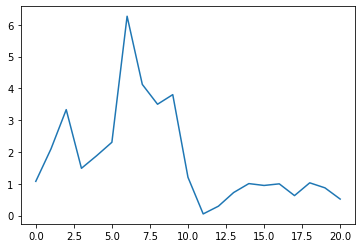

In [23]:
time_period='Future'
indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/EventSet/"
files = [f for f in os.listdir(indy_events_fp) if f.endswith('.csv') and '6hrs' in f]
files = np.sort(files)
file_num = yr_lookup[str(year)]
fp=files[file_num] #files[4] = 6hrs_2066_v2_part0.csv
this_event = read_event(gauge_num, indy_events_fp + fp)
this_event = remove_leading_and_trailing_zeroes(this_event, 0.1)

print(this_event['precipitation (mm)'].sum())
print(len(this_event))
plt.plot(this_event['precipitation (mm)'])

# Plotting together

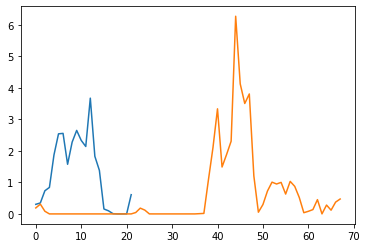

In [17]:
plt.plot(this_event['precipitation (mm)'])
plt.plot(event_df['precipitation (mm)'])

## Explanation
In the new method, the event is slightly longer.  

I believe this is because in Roberto's method, initially the 6hr chunk with the greatest rainfall is identified, and then expansions are made outwards from this. The first two expansions only search quite close to the end of the event, but accept quite small values. The final search will search anywhere within Tb0, but only except new values if they are over 1mm/hr. This means that Roberto's method makes it past the dry gap in the middle, but then as soon as the value goes below 0.1mm/hr then the event is cut-off.

## Are there also circumstances in which they chose compeltely different events?